# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [0]:
try:
    from google.colab import drive
    
    drive.mount('/content/gdrive')
    dataset_path = "gdrive/My Drive/Colab Notebooks/data"
except:
    in_colab = False
    dataset_path = "./data"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# calc_device = "cpu"
calc_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Calculate at ", calc_device)

torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(0)



Calculate at  cuda


## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [0]:
# First, lets load the dataset
data_train = dset.SVHN(dataset_path, split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN(dataset_path, split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [0]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [0]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)
nn_model.to(calc_device)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [0]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x_ld, y_ld) in enumerate(train_loader):
            x = x_ld.to(calc_device)
            y = y_ld.to(calc_device)
            prediction = model(x)   
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if scheduler:
            scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    correct = 0
    total = 0
    for _, (params_ld, corr_answers_ld) in enumerate(loader):
        params = params_ld.to(calc_device)
        corr_answers = corr_answers_ld.to(calc_device)
        predictions = model(params).argmax(dim = 1)
        corr_predicted = predictions == corr_answers
        total += corr_answers.size()[0]
        correct += corr_predicted.sum().item()
        
    return correct / total

%time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.810548, Train accuracy: 0.417176, Val accuracy: 0.545765
Average loss: 1.454735, Train accuracy: 0.583558, Val accuracy: 0.600642
Average loss: 1.379601, Train accuracy: 0.620005, Val accuracy: 0.615112
CPU times: user 55.1 s, sys: 1.03 s, total: 56.2 s
Wall time: 56.3 s


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [0]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace = True),
    nn.Linear(100, 100),
    nn.ReLU(inplace = True),
    nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)
nn_model.to(calc_device)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
%time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Добавьте слой с Batch Normalization

In [0]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace = True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace = True),
    nn.Linear(100, 10),
         )
nn_model.to(calc_device)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
%time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.224680, Train accuracy: 0.216155, Val accuracy: 0.331581
Average loss: 2.065752, Train accuracy: 0.347081, Val accuracy: 0.374172
Average loss: 1.960230, Train accuracy: 0.379978, Val accuracy: 0.407617
Average loss: 1.885785, Train accuracy: 0.416886, Val accuracy: 0.437513
Average loss: 1.827686, Train accuracy: 0.448674, Val accuracy: 0.472118
CPU times: user 59.6 s, sys: 1.02 s, total: 1min
Wall time: 1min


Добавьте уменьшение скорости обучения по ходу тренировки.

In [0]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(    
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace = True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace = True),
    nn.Linear(100, 10),
     )

nn_model.to(calc_device)
stepped_optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(stepped_optimizer, step_size = 2, gamma = 0.5)

# loss_history, train_history, val_history = train_model()
%time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, stepped_optimizer, 10, scheduler=scheduler)

Average loss: 2.188801, Train accuracy: 0.237109, Val accuracy: 0.310627
Average loss: 2.013620, Train accuracy: 0.341467, Val accuracy: 0.375674
Average loss: 1.927476, Train accuracy: 0.385182, Val accuracy: 0.402839
Average loss: 1.882697, Train accuracy: 0.406989, Val accuracy: 0.417582
Average loss: 1.851529, Train accuracy: 0.420895, Val accuracy: 0.426933
Average loss: 1.833001, Train accuracy: 0.429512, Val accuracy: 0.440243
Average loss: 1.818661, Train accuracy: 0.434802, Val accuracy: 0.442837
Average loss: 1.810496, Train accuracy: 0.439187, Val accuracy: 0.441130
Average loss: 1.803787, Train accuracy: 0.441405, Val accuracy: 0.443792
Average loss: 1.800283, Train accuracy: 0.442224, Val accuracy: 0.446318
CPU times: user 3min 13s, sys: 3.8 s, total: 3min 16s
Wall time: 3min 17s


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [0]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    predictions = np.zeros(len(indices), np.int)
    ground_truth = np.zeros(len(indices), np.int)

    for i in range(len(indices)):
        X = dataset[indices[i]][0].view(1, *(dataset[indices[i]][0].shape))
        calculated = model(X.to(calc_device))
        predictions[i] = calculated.argmax(dim = 1)
        ground_truth[i] = dataset[indices[i]][1]
    
    return predictions, ground_truth

# Evaluate model on validation
%time predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

CPU times: user 19.9 s, sys: 275 ms, total: 20.2 s
Wall time: 20.2 s


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

![image.png](attachment:image.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

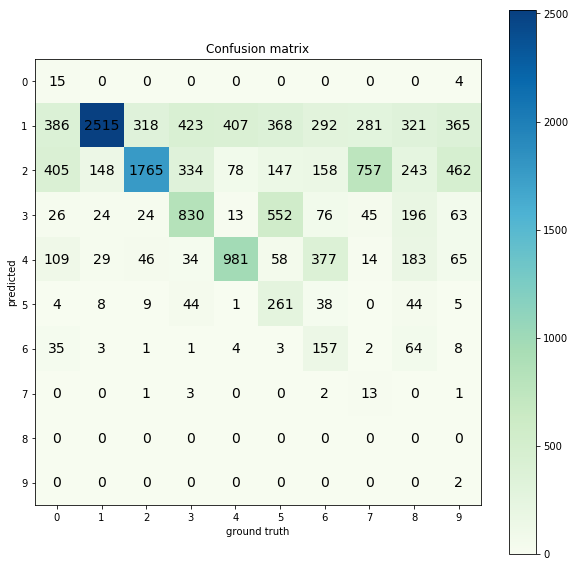

In [0]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    confusion_matrix = np.zeros((10,10), np.int)
    
    for i in range(predictions.shape[0]):
        confusion_matrix[predictions[i], ground_truth[i]] += 1
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

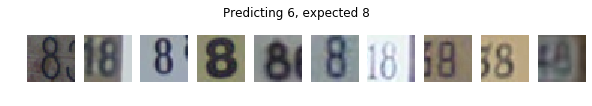

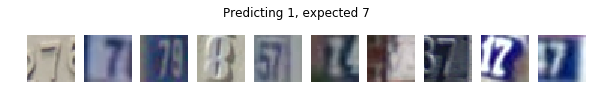

In [0]:
data_train_images = dset.SVHN(dataset_path, split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    title = "Predicting " + str(predicted_class) + ", expected " + str(gt_class)
#     print(predictions.type, ground_truth.type)
    predicted_indices = predictions == predicted_class
    ground_truth_indices = groud_truth == gt_class
    
    visualize_images(val_indices[predicted_indices & ground_truth_indices], data, title)
    #raise Exception("Not implemented")
    

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [0]:
#     predicted_indices = predictions == 1
#     ground_truth_indices = gt == 7
#     valid_np = np.array(val_indices)
#     visualize_images(valid_np[predicted_indices & ground_truth_indices], data_train_images, "")
#     print(valid_np[predicted_indices & ground_truth_indices])
#     print(data_train[32138])
    result = np.histogram([data_train[i][1] for i in train_indices])
    print(result)
        


(array([ 3968, 11134,  8421,  6828,  5974,  5493,  4627,  4483,  3994,
        3684]), array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))


In [42]:
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(0)

nn_model = nn.Sequential(    
    Flattener(),
    nn.Linear(3 * 32 * 32, 500),
    nn.ReLU(inplace = True),
    nn.Linear(500, 10),
     )

nn_model.to(calc_device)
# stepped_optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5)
optimizer = optim.Adagrad(nn_model.parameters(), lr=1e-2)

# optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
# loss_history, train_history, val_history = train_model()
%time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)
# %time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, stepped_optimizer, 10, scheduler)

Average loss: 1.919801, Train accuracy: 0.581647, Val accuracy: 0.671695
Average loss: 0.874267, Train accuracy: 0.737177, Val accuracy: 0.753532
Average loss: 0.744689, Train accuracy: 0.778231, Val accuracy: 0.777763
Average loss: 0.663699, Train accuracy: 0.806129, Val accuracy: 0.784725
Average loss: 0.608812, Train accuracy: 0.822237, Val accuracy: 0.806225
Average loss: 0.565703, Train accuracy: 0.835631, Val accuracy: 0.824995
Average loss: 0.534868, Train accuracy: 0.844743, Val accuracy: 0.822265
Average loss: 0.505783, Train accuracy: 0.855595, Val accuracy: 0.832571
Average loss: 0.483727, Train accuracy: 0.860748, Val accuracy: 0.840966
Average loss: 0.463262, Train accuracy: 0.866362, Val accuracy: 0.829158
CPU times: user 3min 9s, sys: 4.16 s, total: 3min 13s
Wall time: 3min 14s


In [43]:
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(0)

nn_model = nn.Sequential(    
    Flattener(),
    nn.Linear(3 * 32 * 32, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(inplace = True),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace = True),
    nn.Linear(100, 10),
     )

nn_model.to(calc_device)
# stepped_optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5)
optimizer = optim.Adagrad(nn_model.parameters(), lr=1e-2)

# optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
# loss_history, train_history, val_history = train_model()
%time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)
# %time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, stepped_optimizer, 10, scheduler)

Average loss: 1.295633, Train accuracy: 0.583660, Val accuracy: 0.670193
Average loss: 0.840573, Train accuracy: 0.737331, Val accuracy: 0.763497
Average loss: 0.715256, Train accuracy: 0.776081, Val accuracy: 0.797761
Average loss: 0.645237, Train accuracy: 0.798297, Val accuracy: 0.797079
Average loss: 0.602477, Train accuracy: 0.810924, Val accuracy: 0.819261
Average loss: 0.564838, Train accuracy: 0.824438, Val accuracy: 0.829431
Average loss: 0.536333, Train accuracy: 0.832935, Val accuracy: 0.822742
Average loss: 0.514728, Train accuracy: 0.838412, Val accuracy: 0.835370
Average loss: 0.495889, Train accuracy: 0.846261, Val accuracy: 0.834824
Average loss: 0.477629, Train accuracy: 0.851227, Val accuracy: 0.844720
CPU times: user 3min 20s, sys: 4.2 s, total: 3min 24s
Wall time: 3min 25s


In [62]:
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(0)

nn_model = nn.Sequential(    
    Flattener(),
    nn.Linear(3 * 32 * 32, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(inplace = True),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace = True),
    nn.Linear(100, 10),
     )

nn_model.to(calc_device)
stepped_optimizer = optim.Adagrad(nn_model.parameters(), lr=1e-2, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(stepped_optimizer, step_size = 2, gamma = 0.5)
# optimizer = optim.Adagrad(nn_model.parameters(), lr=1e-2)

# optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
# loss_history, train_history, val_history = train_model()
# %time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)
# %time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, stepped_optimizer, 10)
%time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, stepped_optimizer, 12, scheduler)

Average loss: 1.351311, Train accuracy: 0.565369, Val accuracy: 0.612586
Average loss: 0.895164, Train accuracy: 0.720882, Val accuracy: 0.746365
Average loss: 0.711069, Train accuracy: 0.782531, Val accuracy: 0.801584
Average loss: 0.657264, Train accuracy: 0.799526, Val accuracy: 0.803153
Average loss: 0.602912, Train accuracy: 0.813364, Val accuracy: 0.824244
Average loss: 0.581375, Train accuracy: 0.822868, Val accuracy: 0.830797
Average loss: 0.554657, Train accuracy: 0.831963, Val accuracy: 0.832093
Average loss: 0.545818, Train accuracy: 0.834505, Val accuracy: 0.837144
Average loss: 0.536098, Train accuracy: 0.837764, Val accuracy: 0.837349
Average loss: 0.529701, Train accuracy: 0.840631, Val accuracy: 0.838851
Average loss: 0.522371, Train accuracy: 0.841808, Val accuracy: 0.839874
Average loss: 0.519115, Train accuracy: 0.844282, Val accuracy: 0.837963
CPU times: user 4min 4s, sys: 5.02 s, total: 4min 9s
Wall time: 4min 10s


In [51]:
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(0)

nn_model = nn.Sequential(    
    Flattener(),
    nn.Linear(3 * 32 * 32, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(inplace = True),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace = True),
    nn.Linear(100, 10),
     )

nn_model.to(calc_device)
# stepped_optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5)
optimizer = optim.RMSprop(nn_model.parameters(), lr=5e-3)

# optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
# loss_history, train_history, val_history = train_model()
%time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)
# %time loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, stepped_optimizer, 10, scheduler)

Average loss: 1.298677, Train accuracy: 0.575214, Val accuracy: 0.666644
Average loss: 0.893731, Train accuracy: 0.719602, Val accuracy: 0.745546
Average loss: 0.778104, Train accuracy: 0.756237, Val accuracy: 0.781926
Average loss: 0.709333, Train accuracy: 0.778504, Val accuracy: 0.775032
Average loss: 0.666995, Train accuracy: 0.790431, Val accuracy: 0.805201
Average loss: 0.624925, Train accuracy: 0.805293, Val accuracy: 0.814552
Average loss: 0.594587, Train accuracy: 0.814763, Val accuracy: 0.799741
Average loss: 0.572233, Train accuracy: 0.820991, Val accuracy: 0.821855
Average loss: 0.554846, Train accuracy: 0.825513, Val accuracy: 0.818374
Average loss: 0.534786, Train accuracy: 0.833072, Val accuracy: 0.817350
CPU times: user 3min 23s, sys: 4.51 s, total: 3min 27s
Wall time: 3min 28s


In [63]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8171
